In [2]:
import torch
from sklearn.datasets import fetch_openml
import numpy as np
import matplotlib.pyplot as plt

In [3]:
mnist = fetch_openml('mnist_784', version = 1)
X, Y = mnist['data'], mnist['target']

X_train, X_test, y_train, y_test = X[:60000]/255., X[60000:]/255. , Y[:60000].astype(np.int8), Y[60000:].astype(np.int8)
del X, Y

In [4]:
X_tr = torch.from_numpy(np.array(X_train)).float().cuda()
y_tr = torch.from_numpy(np.array(y_train)).long().cuda()

In [9]:
# clase "Model" heredada de la clase de Pytorch `torch.nn.Module`

class Model(torch.nn.Module):

    # se define el constructor

    def __init__(self, d_in, h, d_out):
        super(Model, self).__init__()

        # se define cada capa de la red
        self.fc1 = torch.nn.Linear(d_in, h)         # capa oculta fully connected que recibe los datos de entrada
        self.relu = torch.nn.ReLU()                 # función de activación para la capa oculta
        self.fc2 = torch.nn.Linear(h, d_out)        # capa fully connected que entrega la predicción

    # creamos la estructura de la red
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [10]:
# Se instancia el modelo creado
d_in = 784                      # dimensión de entrada
h = 100                         # cantidad de nodos en la capa oculta
d_out = 10                      # dimensión del espacio de predicción

model = Model(d_in, h, d_out)
model.to('cuda')                # almacenamos el modelo en la gpu

Model(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=100, out_features=10, bias=True)
)

In [11]:
criterion = torch.nn.CrossEntropyLoss()                       # función de pérdida adecuada para clasificación multivaluada
optimizer = torch.optim.SGD(model.parameters(), lr = 0.7)     # optimizador que minimiza la función de pérdida

# hiperparámetros de la red
epochs = 150
le = 10
l = []

# definimos el entrenamiento del modelo
model.train()

for e in range(1, epochs + 1):
    y_pred = model(X_tr)

    # calculamos la pérdida
    loss = criterion(y_pred, y_tr)
    l.append(loss.item())

    # reiniciamos los gradientes del modelo para evitar acumulación
    optimizer.zero_grad()

    # aplicamos Backpropagation
    loss.backward()

    # actualizamos los pesos en la función de costo
    optimizer.step()

    if not e % le:
        print(f"Epoch {e}/{epochs} Loss {np.mean(l):.5f}")


Epoch 10/150 Loss 1.67419
Epoch 20/150 Loss 1.53889
Epoch 30/150 Loss 1.24830
Epoch 40/150 Loss 1.05780
Epoch 50/150 Loss 0.93525
Epoch 60/150 Loss 0.83832
Epoch 70/150 Loss 0.76384
Epoch 80/150 Loss 0.70573
Epoch 90/150 Loss 0.65910
Epoch 100/150 Loss 0.62065
Epoch 110/150 Loss 0.58801
Epoch 120/150 Loss 0.55982
Epoch 130/150 Loss 0.53522
Epoch 140/150 Loss 0.51355
Epoch 150/150 Loss 0.49429


In [12]:
def softmax(x):
    return torch.exp(x) / torch.exp(x).sum(axis = -1, keepdims = True)
    
def evaluate(x):
    #"preparar" el modelo para generar predicciones
    model.eval()

    y_pred = model(x)
    y_prob = softmax(y_pred)
    return torch.argmax(y_prob, axis = 1)

from sklearn.metrics import accuracy_score

y_pred = evaluate(torch.from_numpy(np.array(X_test)).float().cuda())
accuracy_score(y_test, y_pred.cpu().numpy())

0.9388

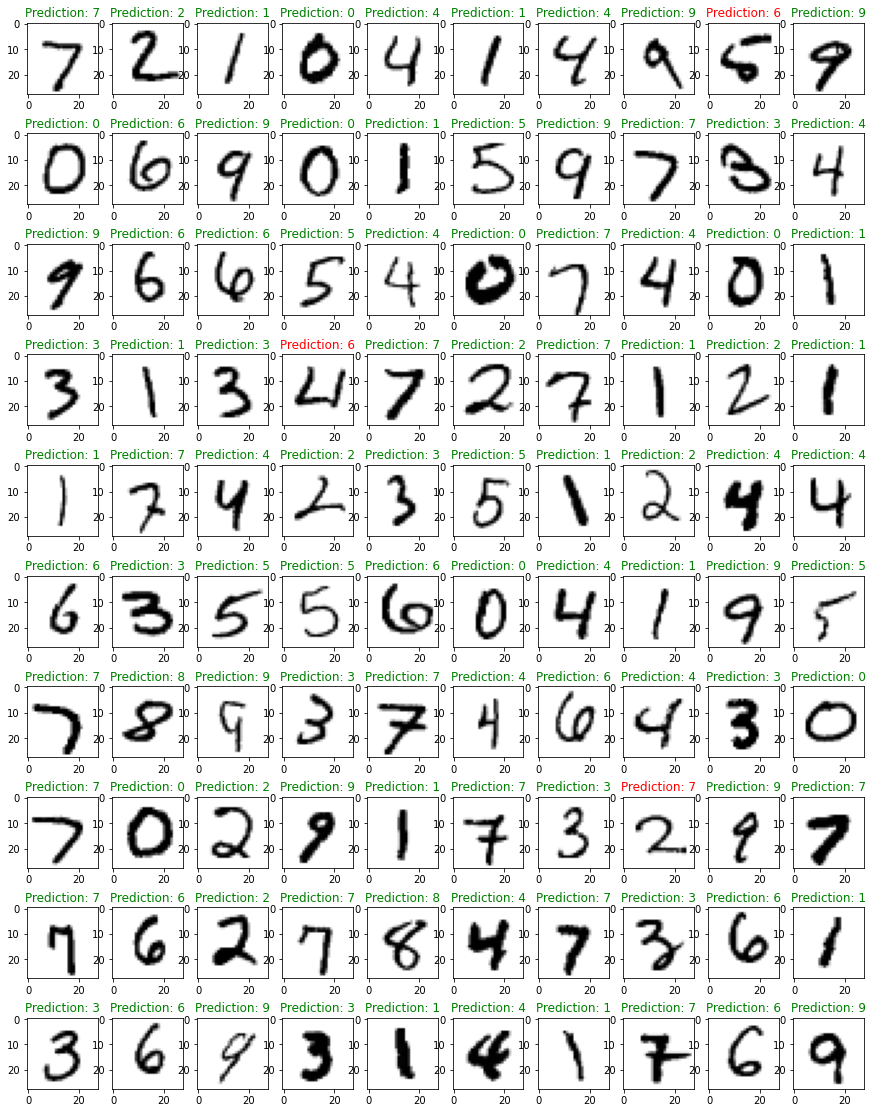

In [13]:
n_row = 10
n_col = 10

fig, axes = plt.subplots(n_row, n_col, figsize = (1.5*n_col, 2*n_row))

for i in range(n_row * n_col):
    image = X_test.iloc[i].values

    ax = axes[i//n_col, i % n_col]
    ax.imshow(np.reshape(image, (28,28)), cmap='gray_r')
    if y_pred[i] != y_test.iloc[i]:
        color = 'red'
    else:
        color = 'green'
    ax.set_title('Prediction: {}'.format(y_pred[i]), color = color)
plt.show()

In [16]:
model.fc1.weight

Parameter containing:
tensor([[ 0.0345, -0.0311, -0.0115,  ...,  0.0282, -0.0209, -0.0186],
        [ 0.0125, -0.0247,  0.0148,  ...,  0.0052,  0.0014, -0.0245],
        [-0.0033, -0.0275,  0.0317,  ...,  0.0214, -0.0098, -0.0355],
        ...,
        [ 0.0165,  0.0161, -0.0072,  ..., -0.0193,  0.0204,  0.0211],
        [ 0.0235,  0.0343,  0.0125,  ..., -0.0152, -0.0209, -0.0180],
        [-0.0185,  0.0066, -0.0338,  ...,  0.0106, -0.0117, -0.0155]],
       device='cuda:0', requires_grad=True)